In [1]:
#import sys
#sys.path.append("/tf/massimal/python/massimal/tools")

In [1]:
# Imports
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
# "Local import" from massimal repository (https://github.com/mh-skjelvareid/massimal)
import annotation, image_render, hyspec_io, misc, hyspec_stats, hyspec_cnn
import importlib
#importlib.reload(hyspec_stats)

import sklearn.preprocessing
import sklearn.decomposition
import math

In [2]:
# Parameters
TILE_SHAPE = (128,128)
TEST_FRAC = 0.3
BATCH_SIZE = 8

In [3]:
# Paths
base_dir = '/media/mha114/Massimal/Bodo_Juvika/Hyperspectral/20220624/'

json_gray = base_dir + 'Area/M_Annotation/20220624_Juvika_AreaDetailed_v1/Annotations - grayscale/label_classes.json'
annotation_dir = base_dir + 'Area/M_Annotation/20220624_Juvika_AreaDetailed_v1/Annotations - grayscale'
hyspec_dir = base_dir + 'Area/2_R_rs'

# hyspec_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC'

# json_gray = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/label_classes.json'
# annotation_dir = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/Selected_Annotation_Images'
# hyspec_dir = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC'

In [4]:
# Find paths to annotated images
ann_file_paths_str = misc.file_pattern_search(annotation_dir,'*.png')
ann_file_paths = [pathlib.Path(fn) for fn in ann_file_paths_str]
for p in ann_file_paths:
    print(p.name)

Juvika_June2022_Pika_L_12-RGB.png
Juvika_June2022_Pika_L_13-RGB.png
Juvika_June2022_Pika_L_16-RGB.png


In [5]:
# Read annotation metadata file, show classes
class_dict = annotation.read_hasty_metadata(json_gray)
for class_name,class_ind in class_dict.items():
    print(f'{class_name}: {class_ind}')

Sand: 1
Seagrass: 2
Rockweed: 3
Blue mussels: 4
Deep water: 5
Turf algae: 6


In [6]:
# Loop through images, spilt into tiles
hyspec_tiles = []
annotation_tiles = []
for annotation_file in ann_file_paths:
    # Load hyperspectral image
    hyspec_file = pathlib.Path(hyspec_dir) / (annotation_file.stem[:-3] + 'Crop Wavelengths.bip.hdr')
    hyspec_image, wl, rgb_ind, metadata = hyspec_io.load_envi_image(hyspec_file)
    # Load annotation image
    class_mask = skimage.io.imread(annotation_file)
    class_mask[np.all(hyspec_image==0,axis=2)] = 0        # Don't include zero data
        
    # Extract tiles
    X_tiles, y_tiles = hyspec_cnn.labeled_image_to_tensor_tiles(hyspec_image,class_mask,TILE_SHAPE,padding='VALID')
    hyspec_tiles.append(X_tiles)
    annotation_tiles.append(y_tiles)

# Concatenate into single tensors
hyspec_tiles = tf.concat(hyspec_tiles,axis=0)
annotation_tiles = tf.concat(annotation_tiles,axis=0)

# Show tensor sizes
print(f'{hyspec_tiles.shape=},\n{annotation_tiles.shape=}')

2023-02-07 16:24:59.084068: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-02-07 16:24:59.084203: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mha114-ThinkPad-P52
2023-02-07 16:24:59.084244: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mha114-ThinkPad-P52
2023-02-07 16:24:59.084477: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-02-07 16:24:59.084547: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-02-07 16:24:59.084567: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3
2023-02-07 16:24:59.085179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

hyspec_tiles.shape=TensorShape([257, 128, 128, 255]),
annotation_tiles.shape=TensorShape([257, 128, 128])


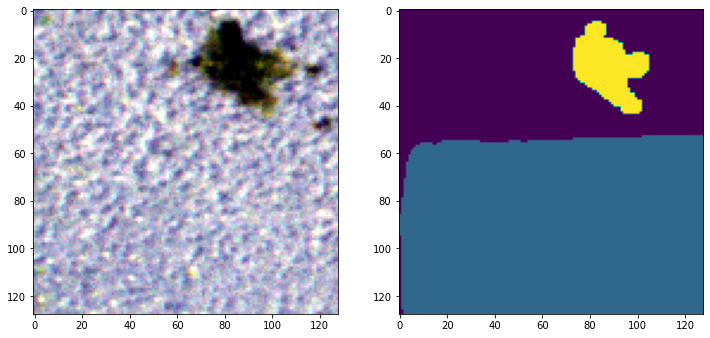

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


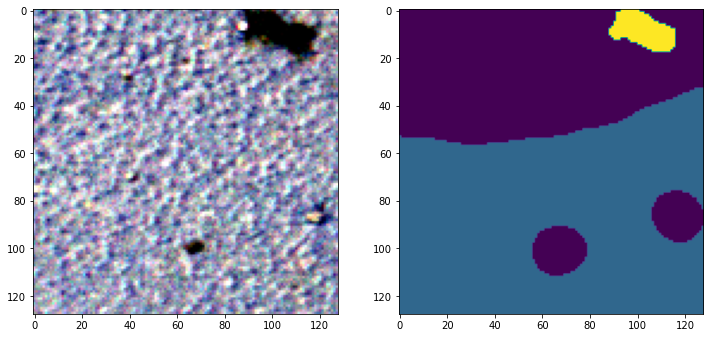

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


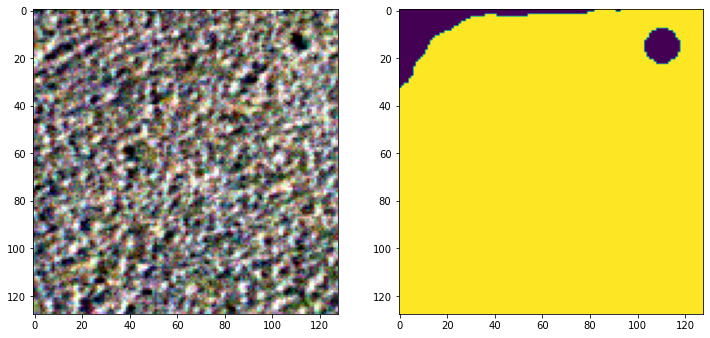

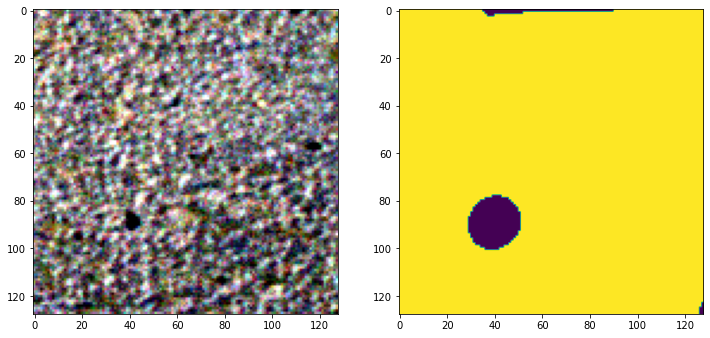

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


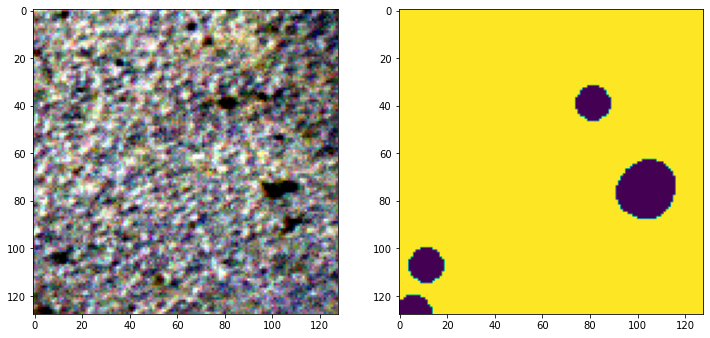

In [7]:
# Show example tile with annotation
for i in range(5):
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].imshow(image_render.percentile_stretch(np.array(hyspec_tiles[i])[:,:,rgb_ind]))
    ax[1].imshow(np.array(annotation_tiles[i]))
    plt.show()

In [8]:
# Collect random spectra from data for building a PCA model
# (Note: Can proably be optimized, this is just a "quick and dirty" way)
hyspec_samples = []
for tile in hyspec_tiles:
    hyspec_samples.append(hyspec_stats.random_sample_image(np.array(tile)))
hyspec_samples = np.concatenate(hyspec_samples,axis=0)
print(f'{hyspec_samples.shape=}')

hyspec_samples.shape=(209880, 255)


In [9]:
#%% Scaling and PCA model
scaler = sklearn.preprocessing.StandardScaler()
X_sc = scaler.fit_transform(hyspec_samples)

pca = sklearn.decomposition.PCA(n_components=10)   
X_pca = pca.fit_transform(X_sc)

In [10]:
# Show explained variance in PCA model
print(f'Explained variance per component (%): {pca.explained_variance_ratio_*100}')
print(f'Total explained variance: {sum(pca.explained_variance_ratio_)*100:.2f} %')

Explained variance per component (%): [61.0611433  33.78649895  1.73481706  0.76374515  0.3325266   0.19922208
  0.11260479  0.09410275  0.07942956  0.06989186]
Total explained variance: 98.23 %


In [11]:
# PCA transformation of image tiles
pca_tiles = pca.transform(np.reshape(np.array(hyspec_tiles),[-1,hyspec_tiles.shape[-1]]))
pca_tiles = pca_tiles.reshape([*hyspec_tiles.shape[0:3],-1])
print(pca_tiles.shape)

(257, 128, 128, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


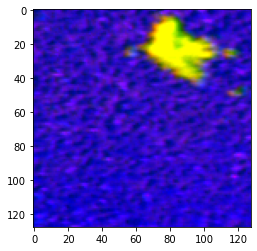

In [12]:
# Show example PCA tile (3 first components as RGB)
plt.imshow(image_render.percentile_stretch(pca_tiles[0,:,:,0:3]))
plt.show()

In [19]:
# Create the U-Net model
unet = hyspec_cnn.unet(input_channels=pca_tiles.shape[-1],
                       output_channels=len(class_dict)+1,
                       first_layer_channels=32,
                       depth = 3)
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 10)]                                                             
                                                                                                  
 augmentation (Sequential)      (None, None, None,   0           ['input_image[0][0]']            
                                10)                                                               
                                                                                                  
 initial_convolution (Conv2D)   (None, None, None,   2912        ['augmentation[0][0]']           
                                32)                                                         

In [20]:
# Create tensorflow dataset
sample_weights = np.array(annotation_tiles!=0,dtype=np.float32)  # All annotated pixels get weight 1, background 0
dataset = tf.data.Dataset.from_tensor_slices((pca_tiles,annotation_tiles,sample_weights))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


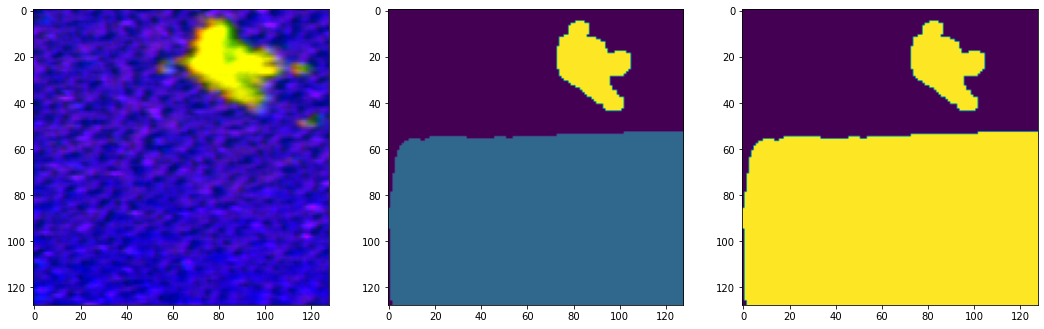

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


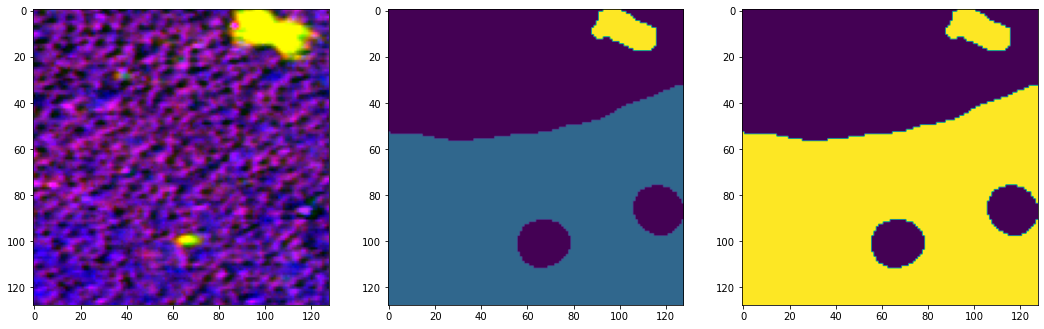

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


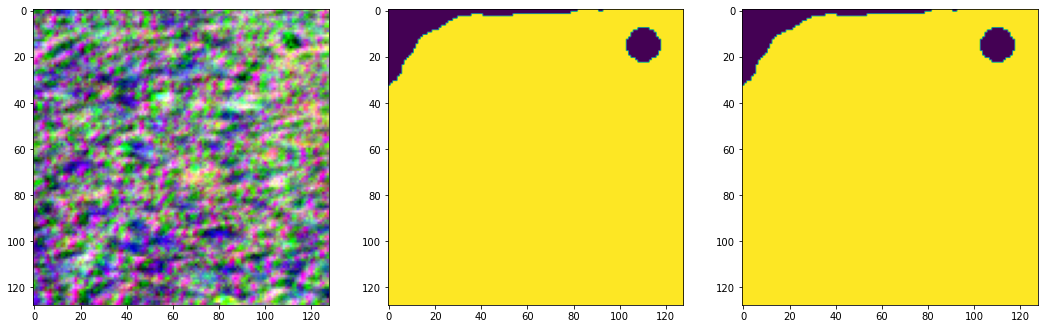

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


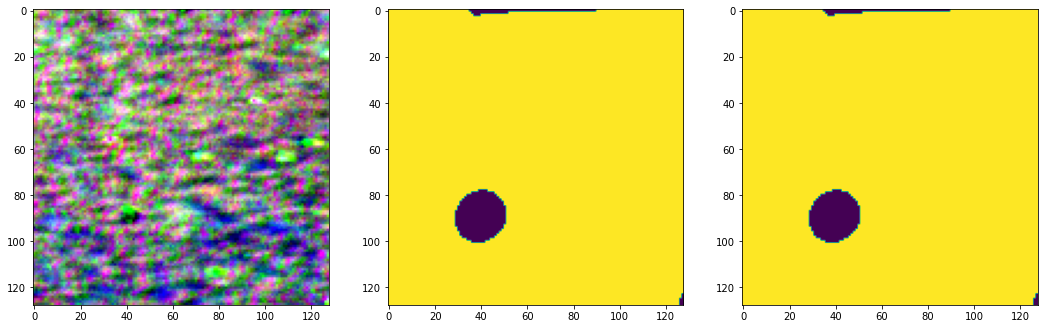

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


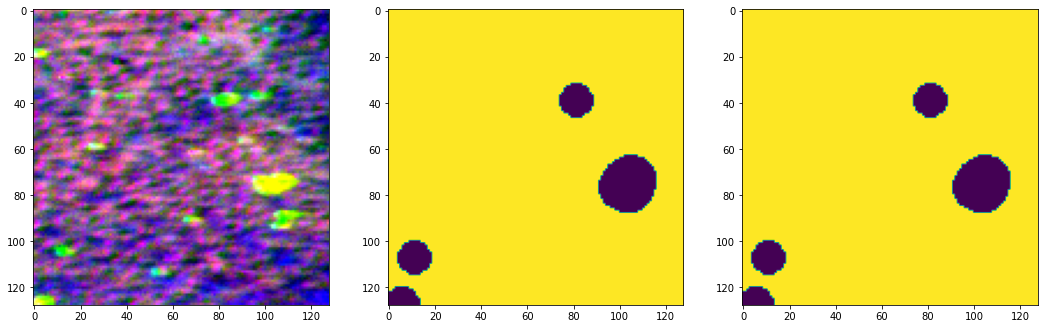

In [21]:
# Show some of the elements of the dataset
for image, mask, weights in dataset.take(5):    # Note: Must interate over dataset to "get" elements
    fig,ax = plt.subplots(1,3,figsize=(18,6))
    ax[0].imshow(image_render.percentile_stretch(np.array(image)[:,:,0:3]))
    ax[1].imshow(np.array(mask))
    ax[2].imshow(np.array(weights))
    plt.show()

In [22]:
# Split into training and validation datasets, create batches
n_val_tiles = int(TEST_FRAC*len(dataset))

dataset = dataset.shuffle(len(dataset))
val_dataset = dataset.take(n_val_tiles).batch(BATCH_SIZE)
train_dataset = dataset.skip(n_val_tiles).batch(BATCH_SIZE)

In [23]:
# Compile model. NOTE: Need smaller learning rate than standard RMSprop
#unet.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",weighted_metrics=[])
unet.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001), loss="sparse_categorical_crossentropy",weighted_metrics=[])
#unet.compile(optimizer=tf.keras.optimizers.RMSprop(0.00005), loss="sparse_categorical_crossentropy",weighted_metrics=[])


In [24]:
# Fit model to dataset
history = unet.fit(train_dataset,
                   epochs=40,
                   validation_data=val_dataset)


Epoch 1/40
23/23 [==============================] - 21s 854ms/step - loss: 0.7879 - val_loss: 1.0302
Epoch 2/40
23/23 [==============================] - 19s 833ms/step - loss: 0.5903 - val_loss: 0.9006
Epoch 3/40
23/23 [==============================] - 19s 810ms/step - loss: 0.4985 - val_loss: 0.9046
Epoch 4/40
23/23 [==============================] - 19s 811ms/step - loss: 0.4585 - val_loss: 0.8468
Epoch 5/40
23/23 [==============================] - 19s 808ms/step - loss: 0.5125 - val_loss: 0.7628
Epoch 6/40
23/23 [==============================] - 19s 808ms/step - loss: 0.4504 - val_loss: 0.7709
Epoch 7/40
23/23 [==============================] - 19s 813ms/step - loss: 0.4054 - val_loss: 0.8151
Epoch 8/40
23/23 [==============================] - 19s 815ms/step - loss: 0.4316 - val_loss: 0.7721
Epoch 9/40
23/23 [==============================] - 19s 808ms/step - loss: 0.4198 - val_loss: 0.6990
Epoch 10/40
23/23 [==============================] - 19s 812ms/step - loss: 0.3724 - val_lo

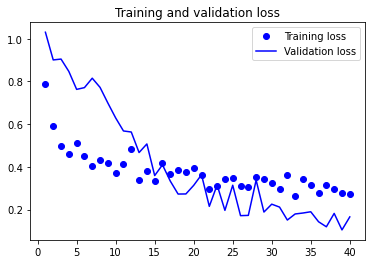

In [25]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [26]:
# PCA transform last hyperspectral image that was read 
pca_image = pca.transform(np.reshape(hyspec_image,(-1,hyspec_image.shape[-1])))
pca_image = np.reshape(pca_image,[*hyspec_image.shape[0:2],-1])
pca_image = hyspec_cnn.pad_image_to_multiple(pca_image,16)

In [27]:
# Run model on image
segm_image = unet.predict(np.expand_dims(pca_image,axis=0))
segm_image = np.argmax(segm_image.squeeze(),axis=2)

1/1 [==============================] - 3s 3s/step


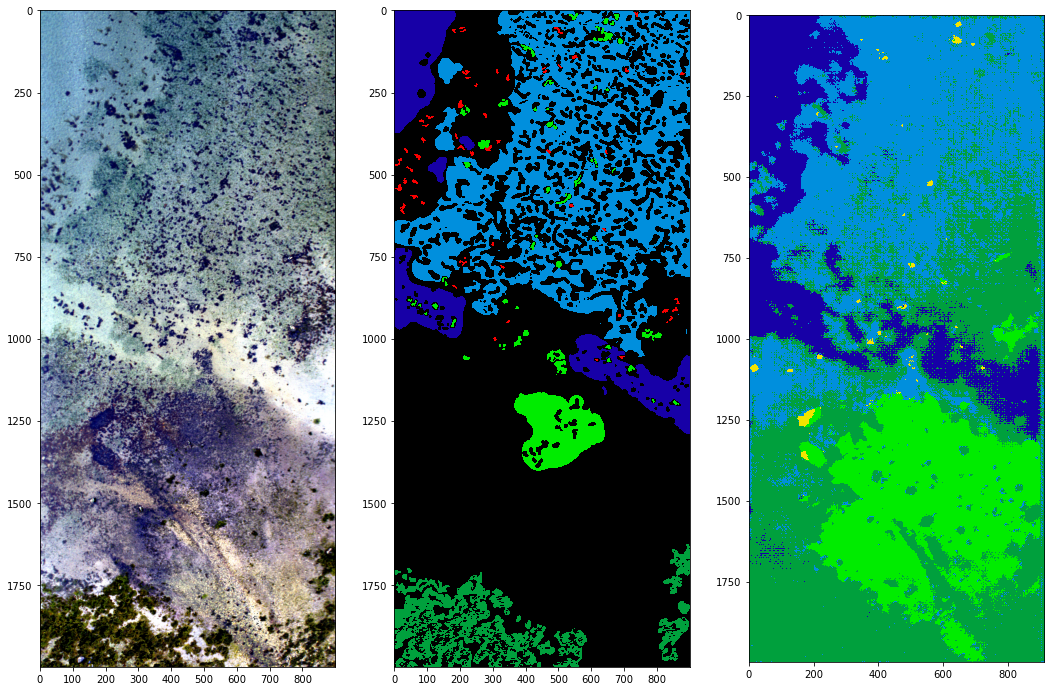

In [39]:
# Show RGB render of image with annotations and predicted classes
fig,ax = plt.subplots(1,3,figsize=(18,18))
ax[0].imshow(image_render.percentile_stretch(hyspec_image[:,:,rgb_ind]))
ax[1].imshow(class_mask,vmin = 0, vmax = 7, cmap='nipy_spectral',interpolation='none')
ax[2].imshow(segm_image,vmin = 0, vmax = 7, cmap='nipy_spectral',interpolation='none')
plt.show()